In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [6]:
v = 0.5
dt = 0.1
num_st_pts = int(v/dt)
num_pts = 50

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
    
def straight(dist, curr_pose, n=num_st_pts):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    x0, y0, t0 = curr_pose
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    x = (xf - x0) * np.linspace(0, 1, n) + x0
    y = (yf - y0) * np.linspace(0, 1, n) + y0
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
    # adjust scaling constant for desired turn radius
     x0, y0, t0 = curr_pose
     theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
     x= x0 + np.cumsum(v*np.cos(theta)*dt)
     y= y0 + np.cumsum(v*np.sin(theta)*dt)
     return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt])
        
    return x, y, t

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

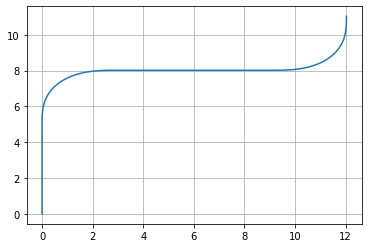

In [10]:
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
x, y, _ = generate_trajectory(route)
plt.figure()
plt.plot(x, y)
plt.grid()

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

[[0, 5]] [0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5] [0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5]


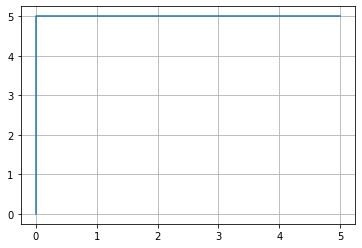

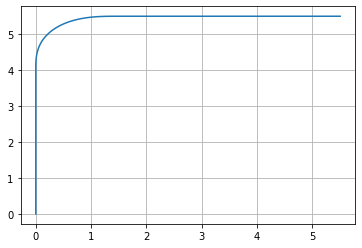

In [7]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 6, 6
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
y2 = [y1[-1]]*s2

x, y = x1[:-1]+x2, y1[:-1]+y2
plt.figure()
plt.plot(x, y)
plt.grid()

#find the corner point and plot it
corners = []
for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
  slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
  if np.abs(slope) > 0.0:
    corners.append([x2, y2])
print(corners,x,y)
# Fix a turn radius r
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
r = 1
route = [("straight", 4),("turn", -90),("straight", 4)]
x, y, _ = generate_trajectory(route)
plt.figure()
plt.plot(x, y)
plt.grid()
# use generate_trajectory() and plot the smooth path

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

In [8]:
def euclidean(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return np.sqrt((x1-x2)**2+(y1-y2)**2)
# use np.load to load a grid of 1s and 0s
# 1 - occupied 0- free
grid = np.load("./data/astar_grid.npy")
# you can define your own start/ end
start = (0, 0)
goal = (13, 5)
# print(grid[0,:])
# visualize the start/ end and the robot's environment
# fig, ax = plt.subplots(figsize=(12,12))
# ax.imshow(grid, cmap=plt.cm.Dark2)
# ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
# ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
# plt.show()
#initialize graph
grid_size = grid.shape
G = nx.grid_2d_graph(*grid_size)
deleted_nodes = 0 # counter to keep track of deleted nodes
#nested loop to remove nodes that are not connected
#free cell => grid[i, j] = 0
#occupied cell => grid[i, j] = 1
num_nodes = 0
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    if grid[i, j] == 1: 
      G.remove_node((i, j))
      num_nodes += 1

print(f"removed {num_nodes} nodes")
print(f"number of occupied cells in grid {np.sum(grid)}")
pos = {(x,y):(y,-x) for x,y in G.nodes()}
# nx.draw(G, pos=pos, node_color='red', node_size=10)
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, "cost")
astar_path = nx.astar_path(G, start, goal, heuristic=euclidean, weight="cost")
print(astar_path)

removed 77 nodes
number of occupied cells in grid 77
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 5), (12, 5), (13, 5)]


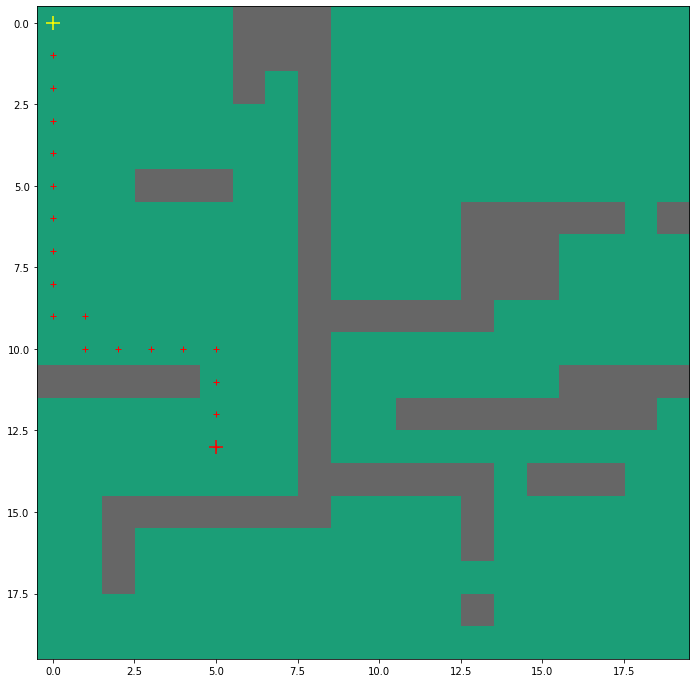

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')

[ 0.00000000e+00  6.12323400e-17  1.22464680e-16  1.83697020e-16
  2.44929360e-16  2.47990977e-16 -9.67986660e-05 -4.78649241e-04
 -1.32576446e-03 -2.81023848e-03 -5.09589435e-03 -8.33804433e-03
 -1.26831587e-02 -1.82684464e-02 -2.52213573e-02 -3.36590210e-02
 -4.36876416e-02 -5.54018718e-02 -6.88841920e-02 -8.42043204e-02
 -1.01418683e-01 -1.20569968e-01 -1.41686796e-01 -1.64783520e-01
 -1.89860181e-01 -2.16902636e-01 -2.45882868e-01 -2.76759482e-01
 -3.09478386e-01 -3.43973669e-01 -3.80168634e-01 -4.17977009e-01
 -4.57304287e-01 -4.98049178e-01 -5.40105160e-01 -5.83362079e-01
 -6.27707782e-01 -6.73029737e-01 -7.19216621e-01 -7.66159839e-01
 -8.13754940e-01 -8.61902910e-01 -9.10511313e-01 -9.59495257e-01
 -1.00877817e+00 -1.05829238e+00 -1.10797945e+00 -1.15779029e+00
 -1.20768507e+00 -1.25763280e+00 -1.30761075e+00 -1.35760358e+00
 -1.40760212e+00 -1.45760203e+00 -1.50760203e+00 -1.50760203e+00
 -2.00760203e+00 -2.50760203e+00 -3.00760203e+00 -3.50760203e+00
 -3.55760203e+00 -3.60760

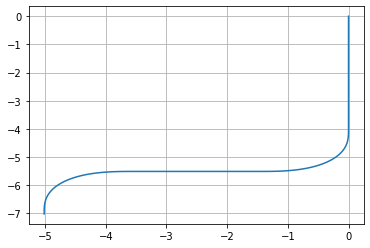

In [13]:
route = [("straight", 4),("turn", -90),("straight", 2), ("turn",90)]
init_pose = (0, 0,-np.pi/2)
x, y, _ = generate_trajectory(route, init_pose)
plt.figure()
plt.plot(x, y)
plt.grid()
print(x,y)

This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs